# **`Feature Extraction`**
## Transfer Learning Part 1

Things we try to improve our model performance:

* Adjust optimizer, learning rate
    * Too noisy learning, fluctuating learning curve? -> Lower Learning rate, increase batch size
    * Too slow learning -> Increase learning rate, use `LearningRateScheduler`
    * Hit a plateau in learning? -> `ReduceLROnPlateau`
    
* Not able to learn on the training set -> training set loss too high? -> High bias -> Underfitting
    * Complexify the model, add more layers, change architecture, give more hints/freedom for model to learn 
    * Relax regularizers. Some things may have regularization `effect`.
    * Even data augmentation can make it harder for model to learn patterns.
* Performing well on training set but not on validation/test set? -> High variance
    * Simplify the model -> Remove layers, reduce redundant information
    * Regularize, augment the dataset
* Even after making the model too complex, the model fails to learn -> **Transfer Learning**


## Transfer Learning

* Use existing neural networks trained on similar task as your own
    * Directly use it if the task is almost exactly as it is
    * Change top/output layer if the end task is a bit different and retrain last layer
    * Gradually unfreeze from top layers and train slowly
    * Use it as a feature extractor, and design your own architecture around it
* Different types of transfer learning:

    - **As is Transfer Learning**
    - **Feature Extraction Transfer Learning**
    - **Fine Tuning Transfer Learning**
    
    
![Kinds of Transfer Learning](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-different-kinds-of-transfer-learning.png)
    
* The initial layers of a network learn the low level features like edges, subtle shapes, sort of building blocks which are combined in non-linear ways to identify high level features such as eyes, ears, nose, for example in a Face detection task

* For an image classification task, we can take patterns a large model has learned from a very big image dataset such as [ImageNet](http://www.image-net.org/) (more than 10,000,000 images in over 10,000 categories). The knowledge/patterns/features learned on such a task will likely be useful for any other image classification task (atleast that is the hope!)

* With only 10% of the data for 10-Food-Image-Multiclass-Classification task, using **Transfer Learning**, we can achieve much better performance than our custom trained model from scratch!
* Transfer Learning on varying amounts of data volume
    * Low Volume Data - Use Transfer Learning and only train one or two top layers (or not at all), keep the initial many layers untouched.
    * Medium Volume Data - Use Transfer Learning and train more than a few top layers, add a little more layers, gradual unfreezing of layers
    * Large Volume Data - Use Transfer Learning and experiment with add more layers, gradual unfreezing and retraining all the layers from scratch. Or Train a custom large model of your own (Computation cost)


![Feature Extraction Transfer Learning](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-transfer-learning-feature-extraction.png)




### [Tensorflow Hub](https://www.tensorflow.org/hub)

* A repository for existing model components. You can import, and use a fully trained model on multiple deep learning tasks just using a URL.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.image import ImageDataset, ClassicImageDataDirectory

## Load the data

In [ ]:
DATA_DIR = '../data/10_food_classes_10_percent/'
TARGET_SIZE = (224, 224)

In [ ]:
imgdir = ClassicImageDataDirectory(DATA_DIR, TARGET_SIZE, dtype=np.uint8)

### Explore the data

#### Class names

In [ ]:
imgdir.class_names

('chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi')

#### Counts 

##### Count dataframe

In [ ]:
imgdir.labelcountdf

,label,name,count_train,count_test
0,0,chicken_curry,75,250
1,1,chicken_wings,75,250
2,2,fried_rice,75,250
3,3,grilled_salmon,75,250
4,4,hamburger,75,250
5,5,ice_cream,75,250
6,6,pizza,75,250
7,7,ramen,75,250
8,8,steak,75,250
9,9,sushi,75,250


##### Label counts

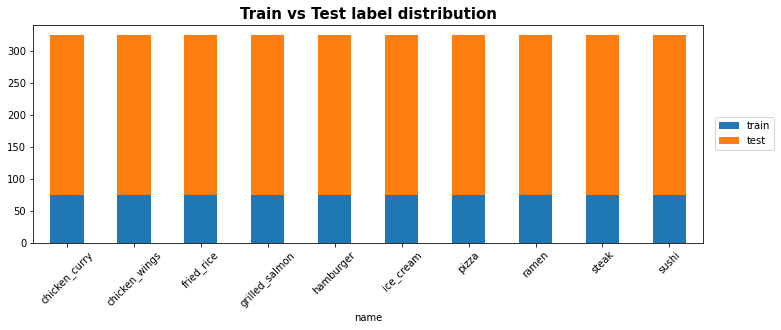

In [ ]:
imgdir.plot_labelcounts();

Very few training examples (75 = 10% of 750) and same number of test examples (250)!

#### View Example Images

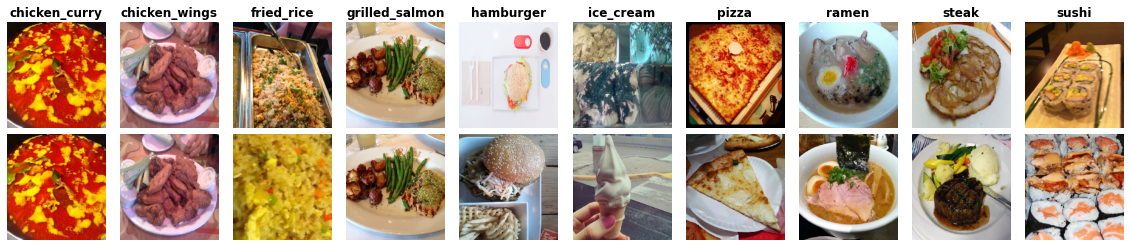

In [ ]:
batch = imgdir.load(64)
imgen = next(batch)
imgen.view_random_images(class_names='all', n_each=2);

## Let's Model it!

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers, callbacks

from src.evaluate import KerasMetrics
from src.visualize import plot_confusion_matrix, plot_keras_model, plot_learning_curve

from sklearn import metrics

#### Setup initial params

In [ ]:
SEED = 42
IMAGE_DIM = (224, 224)
NUM_CHANNELS = 3
INPUT_SHAPE = (*IMAGE_DIM, NUM_CHANNELS)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
CLASSIFICATION_TYPE = 'categorical'
N_CLASSES = imgdir.n_classes

# Set seed
tf.random.set_seed(SEED)

#### Preprocess the data

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255., validation_split=VALIDATION_SPLIT)
test_datagen = ImageDataGenerator(rescale=1/255.)

#### Set up train and test directories

In [ ]:
train_dir = imgdir.train['dir']
test_dir = imgdir.test['dir']

### Import the data from directories

In [ ]:
train_data = train_datagen.flow_from_directory(directory=train_dir, target_size=IMAGE_DIM, 
                                               class_mode=CLASSIFICATION_TYPE, batch_size=BATCH_SIZE,
                                               subset='training', seed=SEED)

validation_data = train_datagen.flow_from_directory(directory=train_dir, target_size=IMAGE_DIM,
                                                    class_mode=CLASSIFICATION_TYPE, batch_size=BATCH_SIZE,
                                                    subset='validation', seed=SEED)

test_data = test_datagen.flow_from_directory(directory=test_dir, target_size=IMAGE_DIM,
                                             class_mode=CLASSIFICATION_TYPE, batch_size=BATCH_SIZE, shuffle=False)

Found 600 images belonging to 10 classes.
Found 150 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up Callbacks (things to run whilst our model trains)

Callbacks are extra functionalities which you can add to your models to be performed during or after training. Most common callbacks:

* [TensorBoard]()
    * Experiment tracking.  
    * Log the performance of model while it trains and view it in a nice visual UI
    * Compare the results of different models on your data
* [ModelCheckpoint]()
    * Save the model as it trains (weight_only option)
    * Stop, resume training from last checkpoint
    * Helpful if training can't be done in one sitting
* [EarlyStopping]()
    * Leave the model to train for an arbitrary amount of epochs
    * Stop it to train automatically when it ceases to improve for a certain number of epochs (`patience` parameter)

### Creating `TensorBoard` callback

Tracking multiple experiments:
* `parent_dir` - This will be the directory where you store all your tensorboard logs
* `task` - The main machine learning task: **10_food_multiclass_classification**
* `experiment` - The current experiment we are running (The model name)

In [ ]:
TENSORBOARD_LOG_DIR = f'../tensorboard_logs'
TASK_NAME = '10_food_multiclass_classification'

In [ ]:
import datetime
import os
def create_tensorboard_callback(experiment, task, parent_dir=TENSORBOARD_LOG_DIR):
    log_dir = os.path.join(parent_dir, task, experiment, datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir)
    print(f'Saving TensorBoard log files to " {log_dir}"')
    return tensorboard_callback

## Creating models using `TensorFlow Hub`

* We can used pretrained/saved models from:
    * TF Save format models (from anywhere)
    * HDF5 saved model (from anywhere)
    * Tensorflow Hub 
    * Keras included models
    
    
* We are mainly going to use these two models from TensorFlow Hub:
    - [ResNetV2](https://arxiv.org/abs/1603.05027) - SOTA CV model 2016
    - [EfficientNet](https://arxiv.org/abs/1905.11946) -SOTA CV model 2019
    
**Note** - SOTA means *State of the Art* models which achieved very high performance on [ImageNet (ILSVRC-2012-CLS)](http://www.image-net.org/)


Steps to find models on TensorFlow Hub:
* Go to [tfhub.dev](tfhub.dev)
* Choose the problem domain i.e. "Image"
* Select the TF version i.e. TF2
* Remove all "Problem Domain" except "Image feature vector"
* Now select a collection -> Select an architecture -> Copy the URL


In [ ]:
tfmodels = {}

In [ ]:
import tensorflow_hub as hub

### URLs of the `TFhub` models

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

# EfficientNet b0 feature vector
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

### Create model

In [ ]:
def create_model_from_tfhub_feature_vector(model_url, name, input_shape=INPUT_SHAPE, num_classes=N_CLASSES):
    '''Creates a simple classification model from TFhub URL'''
    
    # Download the pretrained model and save it as a KerasLayer
    feature_extraction_layer = hub.KerasLayer(model_url, trainable=False, name='feature_extraction_layer', input_shape=input_shape)
    
    # Create the model
    model = tf.keras.models.Sequential([
        feature_extraction_layer,
        layers.Dense(num_classes, activation='softmax', name='output_layer')
    ], name=name)
    
    return model

## `ResNetV2-50`

### Create the model

In [ ]:
# Create
resnet_model = create_model_from_tfhub_feature_vector(resnet_url, name='resnet_v2_50')

# Compile
resnet_model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(), metrics=[KerasMetrics.f1, 'accuracy'])

# Summarise
resnet_model.summary()

Model: "resnet_v2_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


### Fit the model

In [ ]:
history = resnet_model.fit(train_data, steps_per_epoch=len(train_data),
                           validation_data=validation_data, validation_steps=len(validation_data), 
                           callbacks=[create_tensorboard_callback(resnet_model.name, TASK_NAME)], epochs=10)
tfmodels[resnet_model.name] = resnet_model

Saving TensorBoard log files to " ../tensorboard_logs\10_food_multiclass_classification\resnet_v2_50\20210516-192549"
Epoch 1/10
19/19 [==============================] - 17s 891ms/step - loss: 0.1108 - f1: 0.9916 - accuracy: 0.9950 - val_loss: 1.1101 - val_f1: 0.6779 - val_accuracy: 0.6667
Epoch 2/10
19/19 [==============================] - 12s 604ms/step - loss: 0.0982 - f1: 0.9942 - accuracy: 0.9950 - val_loss: 1.1329 - val_f1: 0.6630 - val_accuracy: 0.6467
Epoch 3/10
19/19 [==============================] - 12s 607ms/step - loss: 0.0874 - f1: 0.9958 - accuracy: 0.9950 - val_loss: 1.1126 - val_f1: 0.6666 - val_accuracy: 0.6667
Epoch 4/10
19/19 [==============================] - 12s 611ms/step - loss: 0.0792 - f1: 0.9961 - accuracy: 0.9950 - val_loss: 1.1401 - val_f1: 0.6673 - val_accuracy: 0.6600
Epoch 5/10
19/19 [==============================] - 12s 614ms/step - loss: 0.0708 - f1: 0.9983 - accuracy: 0.9983 - val_loss: 1.1438 - val_f1: 0.6646 - val_accuracy: 0.6667
Epoch 6/10
19/19 

### Learning Curve

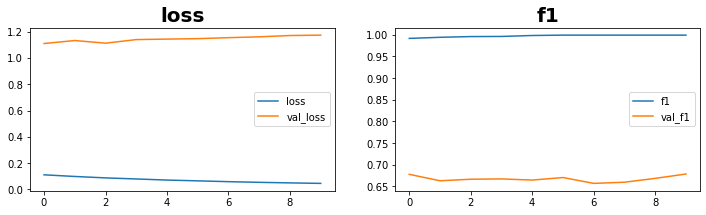

In [ ]:
plot_learning_curve(resnet_model, extra_metric='f1');

Highly overfitted!

### Prediction Evaluation

In [ ]:
%%time
y_test_pred_probs = resnet_model.predict(test_data)
y_test_preds = y_test_pred_probs.argmax(axis=1)

Wall time: 28.4 s


#### Classification report

In [ ]:
print(metrics.classification_report(test_data.labels, y_test_preds, target_names=test_data.class_indices))

                precision    recall  f1-score   support

 chicken_curry       0.71      0.68      0.70       250
 chicken_wings       0.86      0.79      0.82       250
    fried_rice       0.80      0.86      0.83       250
grilled_salmon       0.63      0.62      0.63       250
     hamburger       0.80      0.82      0.81       250
     ice_cream       0.86      0.79      0.82       250
         pizza       0.92      0.92      0.92       250
         ramen       0.86      0.84      0.85       250
         steak       0.63      0.70      0.66       250
         sushi       0.76      0.77      0.76       250

      accuracy                           0.78      2500
     macro avg       0.78      0.78      0.78      2500
  weighted avg       0.78      0.78      0.78      2500



## `EfficentNetB0`

### Create the model

In [ ]:
# Download and create the model
efficientnet_model = create_model_from_tfhub_feature_vector(efficientnet_url, name='efficientnet_b0')

# Compile
efficientnet_model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(), metrics=[KerasMetrics.f1, 'accuracy'])

# Summary
efficientnet_model.summary()

Model: "efficientnet_b0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


### Fit the model

In [ ]:
history = efficientnet_model.fit(train_data, steps_per_epoch=len(train_data), validation_data=validation_data, validation_steps=len(validation_data),
                                 epochs=10, callbacks=[create_tensorboard_callback(efficientnet_model.name, TASK_NAME)])
tfmodels[efficientnet_model.name] = efficientnet_model

Saving TensorBoard log files to " ../tensorboard_logs\10_food_multiclass_classification\efficientnet_b0\20210516-193051"
Epoch 1/10
19/19 [==============================] - 44s 1s/step - loss: 2.0636 - f1: 0.0057 - accuracy: 0.3246 - val_loss: 1.5061 - val_f1: 0.1257 - val_accuracy: 0.6467
Epoch 2/10
19/19 [==============================] - 13s 695ms/step - loss: 1.2160 - f1: 0.2876 - accuracy: 0.7482 - val_loss: 1.1489 - val_f1: 0.3767 - val_accuracy: 0.7867
Epoch 3/10
19/19 [==============================] - 12s 630ms/step - loss: 0.8301 - f1: 0.6558 - accuracy: 0.8440 - val_loss: 0.9750 - val_f1: 0.5830 - val_accuracy: 0.8200
Epoch 4/10
19/19 [==============================] - 11s 544ms/step - loss: 0.6529 - f1: 0.7883 - accuracy: 0.8650 - val_loss: 0.8855 - val_f1: 0.6434 - val_accuracy: 0.8133
Epoch 5/10
19/19 [==============================] - 11s 567ms/step - loss: 0.5309 - f1: 0.8535 - accuracy: 0.8831 - val_loss: 0.8293 - val_f1: 0.7041 - val_accuracy: 0.8133
Epoch 6/10
19/19 

### Learning Curve

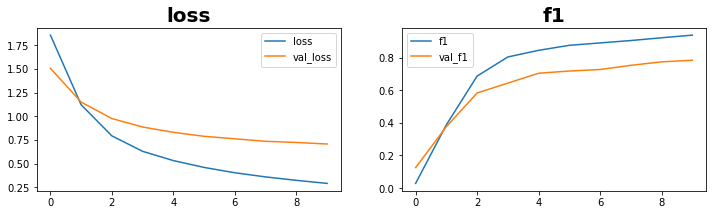

In [ ]:
plot_learning_curve(efficientnet_model, extra_metric='f1');

This is far better fitted! This seems to largely have reduced overfitting

### Prediction evaluation

In [ ]:
y_test_pred_probs = efficientnet_model.predict(test_data)
y_test_preds = y_test_pred_probs.argmax(axis=1)

#### Classification report

In [ ]:
print(metrics.classification_report(test_data.labels, y_test_preds, target_names=test_data.class_indices))

                precision    recall  f1-score   support

 chicken_curry       0.71      0.68      0.70       250
 chicken_wings       0.86      0.79      0.82       250
    fried_rice       0.80      0.86      0.83       250
grilled_salmon       0.63      0.62      0.63       250
     hamburger       0.80      0.82      0.81       250
     ice_cream       0.86      0.79      0.82       250
         pizza       0.92      0.92      0.92       250
         ramen       0.86      0.84      0.85       250
         steak       0.63      0.70      0.66       250
         sushi       0.76      0.77      0.76       250

      accuracy                           0.78      2500
     macro avg       0.78      0.78      0.78      2500
  weighted avg       0.78      0.78      0.78      2500



## Comparing models using TensorBoard

**Uploading**
```
tensorboard dev upload --logdir tensorboard_logs/10_food_multiclass_classification/ \
    --name "10 Food Multiclass Classification" \
    --description "Classification model comparison on food classification task" \
    --one_shot
    
```
**Listing**
```
tensorboard dev list
```

**Deleting**
```
tensorboard dev delete --experiment_id iRFLjXj6Q92Po9UDOD1UGg
```